**IMDB dataset:** a set of 50,000 highly polarized reviews from the
Internet Movie Database. They’re split into 25,000 reviews for training and 25,000
reviews for testing, each set consisting of 50% negative and 50% positive reviews.

The reviews (sequences of words) **have been turned into
sequences of integers**, where each integer stands for a specific word in a dictionary.

The variables `train_data` and `test_data` are lists of reviews; each review is a list of
word indices (encoding a sequence of words). `train_labels` and `test_labels` are
lists of 0s and 1s, where **0 stands for negative and 1 stands for positive**

In [1]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

----------------------------------------------------------------------------------
For kicks, here’s how you can quickly decode one of these reviews back to English
words

In [2]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[5]])

1654784/1641221 [==============================] - 1s 1us/step


----------------------------------------------------------------------------------------------

# Preparing the data
We can’t feed lists of integers into a neural network. They have to be turned into
tensors. There are two ways to do that:
- Pad the lists so that they all have the same length, turn them into an integer tensor of shape ```(samples, word_indices)``` , and then use as the first layer in your network a layer capable of handling such integer tensors (the **Embedding layer**, which we’ll cover in detail later in the book).
- **One-hot encode** your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a **Dense layer**, capable of handling floating-point vector data.

In [3]:
import numpy as np
#from tensorflow.keras.utils import to_categorical

Manually:

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [5]:
x_train = vectorize_sequences(train_data)

In [6]:
x_test = vectorize_sequences(test_data)

Using keras ```to_categorical```:

In [7]:
#x_train = to_categorical(train_data)

In [8]:
#x_train

Vectorize the labels

In [9]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Building the network
The **input data is vectors**, and the **labels are scalars**: *the easiest setup we can encounter*.
A type of network that performs well on such a problem is
a simple stack of fully connected (**Dense**) layers with **relu activations**

A **relu** (rectified linear unit) is a function **meant to zero out negative values**.

=> ```Dense(16, activation='relu')``` where 16 is the number of *hidden units* of the layer.

A hidden unit is a dimension in the representation space of the layer. The *weight matrix W* will have shape ```(input_dimension, hidden units)```

A **Dense layer with a relu activation** implements the following chain of tensor operations:
```output = relu(dot(W, input) + b)```
the dot product with W will project the input data onto a hidden units-dimensional representation space (and then you’ll add the bias vector b and apply the relu operation)

>Intuitively, the dimensionality of your representation space is *“how much freedom you’re allowing the network to have when learning internal representations.”* Having more hidden units (a higher-dimensional representation space) allows your network to learn more-complex representations, but can be expensive and lead to overfitting.

The final layer will use a **sigmoid activation so as to output a probability**, between 0 (not likely) and 1 (likely).

In [10]:
from keras import models
from keras import layers

In [11]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is a binary classification problem and the output of your network is a probability. So, for **loss function**, crossentropy is the best option when dealing with probabilities outputs. Crossentropy measures the distance between probability distributions or, in this case, between the ground-truth distribution and the predictions.

For the **optimizer**, rmsprop.

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Validation of the approach
Create a validation set by setting apart 10,000 samples from the original training data

In [13]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Train the model for 4 epochs (4 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. 

At the same time, monitor loss and accuracy on the 10,000 samples set apart. To do so, pass the validation data as the validation_data argument:

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 29ms/step - loss: 0.5349 - accuracy: 0.7740 - val_loss: 0.4085 - val_accuracy: 0.8651
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.3118 - accuracy: 0.9038 - val_loss: 0.3070 - val_accuracy: 0.8855
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2212 - accuracy: 0.9279 - val_loss: 0.3151 - val_accuracy: 0.8723
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1717 - accuracy: 0.9474 - val_loss: 0.2785 - val_accuracy: 0.8876
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1377 - accuracy: 0.9582 - val_loss: 0.2936 - val_accuracy: 0.8833
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1137 - accuracy: 0.9650 - val_loss: 0.2995 - val_accuracy: 0.8848
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0943 - accuracy: 0.9733 - val_loss: 0.3157 - val_accuracy: 0.8829
Epoch 8/20
30/

The call to ```model.fit()``` returns a ```History``` object. This object has a member ```history```, which is a dictionary containing data about everything that happened during training:

```>>> history_dict = history.history```    
```>>> history_dict.keys()```    
```[u'acc', u'loss', u'val_acc', u'val_loss']```

The dictionary contains four entries: one per metric that was being monitored during training and during validation.

In [15]:
import matplotlib.pyplot as plt

Plotting the training and validation **loss**

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

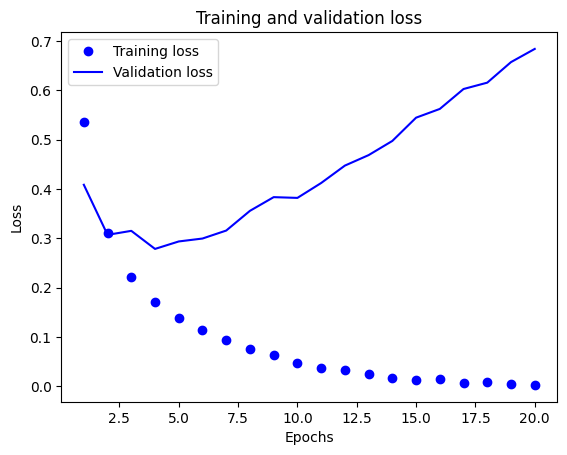

In [17]:

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting the training and validation **accuracy**

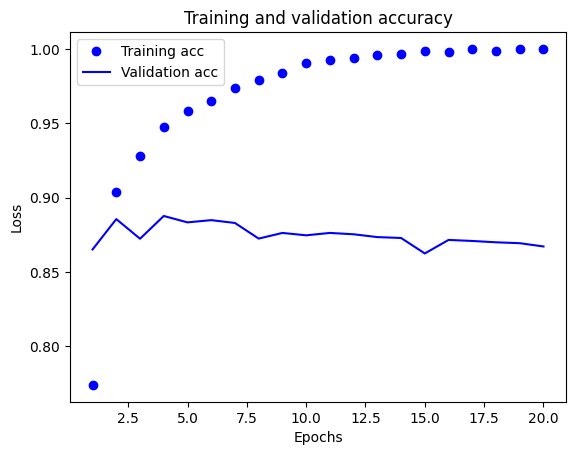

In [18]:
plt.clf()  #Clears the figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**VERY IMPORTANT:** More epochs cause *overfitting*, the training data gets overoptimazed and the learning representation is too specific to the training data, it doesn't generalize outside of the training set. If we train more epochs (for example: 20), we'll see that the *training* loss decrases and the *training* accuracy increased every epoch, **but** the *validation* loss and accuracy seem to peak at the 4th epoch.

### Final results of training
This fairly naive approach achieves an accuracy of 88%, as we can see with:

In [19]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.7367 - accuracy: 0.8523


# Predictions on new data with trained network
The network can be confident for some samples but less confident for others, as we can see with:

In [20]:
model.predict(x_test)

array([[0.00880506],
       [1.        ],
       [0.99468344],
       ...,
       [0.007587  ],
       [0.01277474],
       [0.89907366]], dtype=float32)